# Clutter Analysis - Part 1
*(Notebook version: 1.0 Initial - 2020 04 13)*

This research is inspired by the work of K. Kulpa and their colleges [Kulpa2019]. In their paper they have analysed the bistatic clutter with utilizing a DAB (Digital Audio Broadcast) illuminator. With applying basic data analysis they have revealed that the clutter returns show short-term stability both in amplitude and phase. This provides an opportunity to save computational resources in the clutter cancellation processing stage as the once adaptively estimated filter coefficients could be used multiple times in the next coherently processed batches.

In this research my main goal was to reproduce and verify their results and observations and to extend their work with more measurements and with new aspects of the analysis methodology.
For the investigations I will use measurements from the VEGA Passive Radar database [Peto2020], thus expanding the available observations with new iluuminators, such as FM and DVB-T, and also adding observations from different measurement locations and with different receiver systems.

For the first investigations I use a data set which contains a DVB-T measurement with two receiver channels. It must be noted that in this measurement environment multiple DVB-T illuminators was operated in SFN mode (Single Freuqency Network).


First, I buid up their evaluation environment. To investigate the clutter stability they have calculated the cross-correlation function of the reference and the surveillance channels, as usual for the detection stage, but in this case for the zero-Doppler only.
\begin{equation}
R[m] = \sum_{n=0}^{N-1} x_r[n-m]^* x_s[n],
\end{equation}
where $n$ denotes the index of the discrete time sample, $N$ is the number of samples in the coherently processed interval (CPI), $x_r[n]$ is the $n$-th sample of the reference channel, $x_s[n]$ is the $n$-th sample of the surveillance channel and $^*$ denotes the complex conjugate operation.
They have made the calculations to $N=100000$ samples, which was equivalent to $50 ms$ ($f_s=2 MSps$). For the investigations I am going to use roughly the same amount of coherent processing interval ($T_{CPI}$).

The next script sets up the interface to import data records.

In [1]:
# With the use of this script we can work with
# VEGA database compatible measurements
import IQRecordTools # Util function to import IQ data frames
from os.path import join
import numpy as np

# Set the parameters and the path of the working VEGA dataset
dset_name="VEGAM20200402L2C0S0DVBT"
path_prefix  = join(join("d:",dset_name),"iq")
#path_prefix = join(join(dset_name, "iq"))
start_record_index=95
stop_record_index=115
T=stop_record_index-start_record_index

fname = join(path_prefix, dset_name[0:-4]+"_"+str(start_record_index)+".iqf")
iq_samples, iq_header = IQRecordTools.load_iq(fname)

N = np.size(iq_samples,1)
M = np.size(iq_samples,0)

t_cpi = N/(iq_header.sampling_freq)
print("Number of antenna channels: {:d}".format(M))
print("Number of samples in a CPI: {:d}".format(N))
print("Coherent block size in the data frame: {:.2f} ms".format(t_cpi*10**3))

Number of antenna channels: 2
Number of samples in a CPI: 1048576
Coherent block size in the data frame: 114.69 ms


The actual coherent processing interval is set to $57 ms$ (half size of the recorded blocks, $N=2^{19}$ sample).

To have a formal description, let us introduce the $K$ dimensional cross-correlation vector of the reference and surveillance channels with $\textbf{c}^{(p)} \in \mathcal{C}^{K \times 1}$ at the $p$-th CPI index. Then the $k$-th element of the $\textbf{c}^{(p)}$ vector is
\begin{equation}
c_k^{(p)} = R[k]^{(p)} = \sum_{n=0}^{N-1} {x_r[n-k]^{(p)}}^* {x_s[n]^{(p)}}^*, k= 0 \dots K-1
\end{equation}
The maximum time delay considered for the zero-Doppler clutter component estimation is denoted with $K$. 
The following script loads multiple consequtive records from the specified data set and estimates the zero-Doppler clutter for all the records. The estimated clutter vectors are stored in a matrix, in which each column corresponds to a CPI (record). 



In [2]:
from scipy.signal import correlate
# --- Processing parameters
ref_ch_index  = 0 # Reference channel antenna index
surv_ch_index = 1 # Surveillance channel antenna index
K = 256 # Maximum calculated clutter delay [samples] 
N = 2**19 # Coherent processing interval [samples]

# --- Allocate and initalize ---
ZDV   = np.zeros([K,T], dtype=np.complex) # zero-Doppler vectors
ZDV_t = 0 # used to index the ZDV matrix

# --- Calculation ---
for t in np.arange(start_record_index, stop_record_index,1):    
    print("Processing time index: {:d}".format(t), end="\r")
    # Load IQ samples
    fname = join(path_prefix, dset_name[0:-4]+"_"+str(t)+".iqf")
    iq_samples, iq_header = IQRecordTools.load_iq(fname)
    
    # Calculate zero-Doppler clutter vector
    ZDV[:, ZDV_t] = correlate(iq_samples[surv_ch_index,0:N],iq_samples[ref_ch_index,0:N],mode='full')[N-1:N+K-1]
    ZDV_t += 1


Let us display the resuls. The first figure shows the amplitude variation of the zero-Doppler components over time


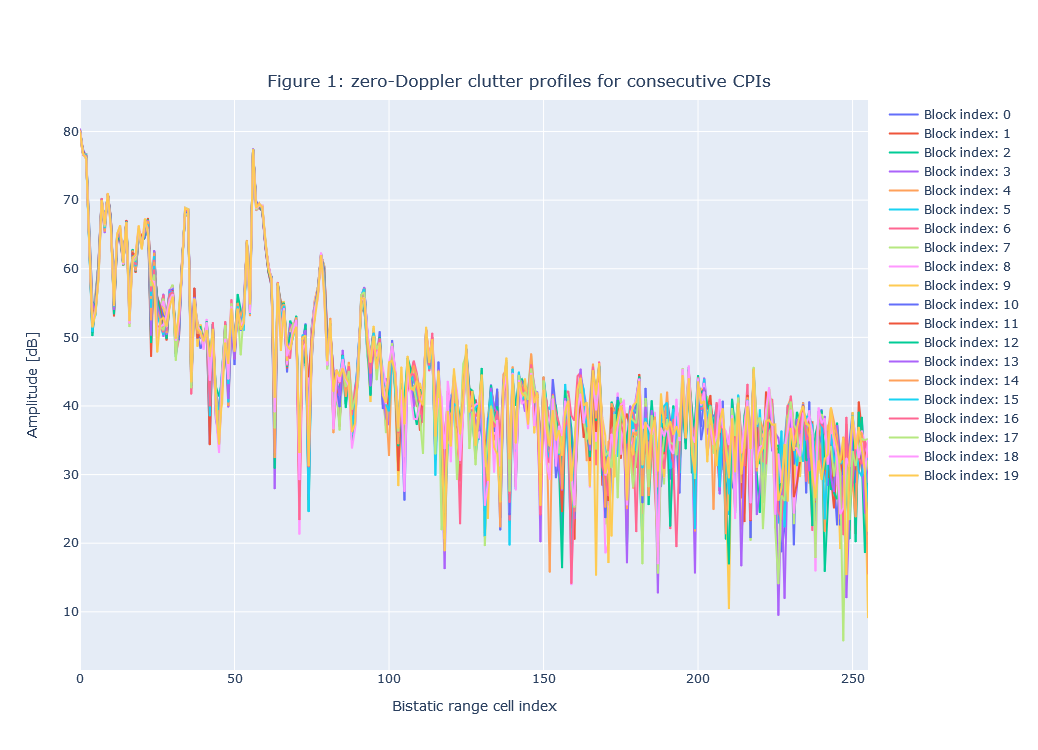

In [3]:
# Import the required libraries for plotting
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode()

#Default figure sizes
fig_w = 1000
fig_h = 750

# Wrap the display script into a function, so we can use it later as well
def display_zdm_1d(ZDV, title):
    """
    Displays the calculated zero-Doppler clutter profiles for the consecutive time indexes
    
    Parameters:
    -----------
        :param: ZDV: zero-Dopplef cluter structured in a matrix
        :param: title: Title of the generated figure
        :global param: fig_w: Figure width
        :global param: fig_h: Figure height
    
    Return:
    -------
        fig: plotly compatible figure object        
    """
    T = np.size(ZDV,1)
    fig=go.Figure()
    x=np.arange(K)
    for t in range(T): # Runs on time indexes
        ZDV_abslog = 20*np.log10(np.abs(ZDV[:,t]))
        fig.add_trace(go.Scatter(x=x, 
                             y=ZDV_abslog, 
                             mode='lines',
                             name=("Block index: "+str(t))))
    fig.update_layout(
        autosize=False,
        width=fig_w,
        height=fig_h,
        yaxis=dict(title_text="Amplitude [dB]"),
        xaxis=dict(title_text="Bistatic range cell index"),
        title={'text': title,        
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
    )
    
    return fig

#Plot the resuls
fig = display_zdm_1d(ZDV, "Figure 1: zero-Doppler clutter profiles for consecutive CPIs")
fig.show()           


To check the stability of the clutter amplitudes and phases we can plot their temporal evaluation on a complex 2D plane. To have a more clean insight, only the first $10$ clutter component is displayed, ($k=0 \dots 9$.)

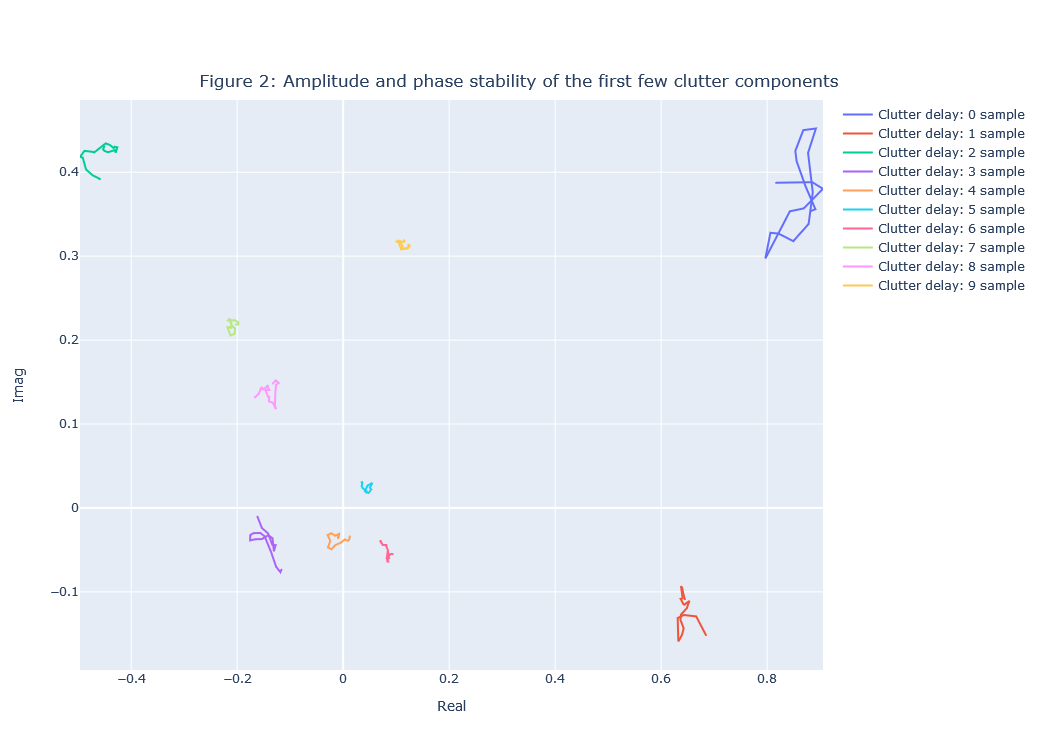

In [4]:
def display_zdm_cplx(ZDV, title):
    """
    Parameters:
    -----------
        :param: ZDV: zero-Dopplef cluter structured in a matrix
        :param: title: Title of thw generated figure
        :global param: fig_w: Figure width
        :global param: fig_h: Figure height
        
    """
    fig=go.Figure()
    absmax = np.max(np.abs(ZDV)) # Used for normalization
    displ_max_clutter_delay = 10 #T see all:np.size(ZDV,0)
    for k in range(displ_max_clutter_delay):# Runs on clutter delay bins
        Rk_cent_real = ZDV[k,:].real / absmax
        Rk_cent_imag = ZDV[k,:].imag / absmax
        fig.add_trace(go.Scatter(x=Rk_cent_real, 
                             y=Rk_cent_imag, 
                             mode='lines',
                             name=("Clutter delay: "+str(k)+" sample")))
    fig.update_layout(
        autosize=False,
        width=fig_w,
        height=fig_h,
        yaxis=dict(title_text="Imag"),
        xaxis=dict(title_text="Real"),
        title={'text': title,        
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
    )
    return fig

#Plot the resuls
fig = display_zdm_cplx(ZDV, "Figure 2: Amplitude and phase stability of the first few clutter components" )
fig.show()           


The next figure shows the evauluation of the amplitude of the zero-Doppler clutter components over time on a 2D colored map.

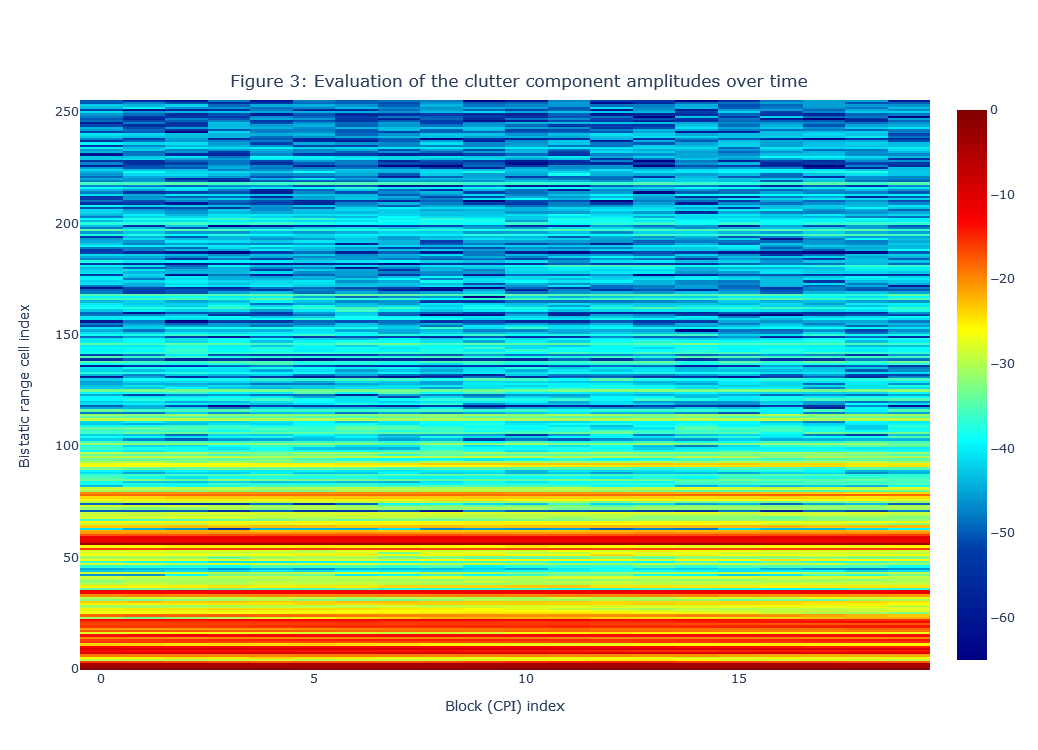

In [5]:
dyn_range = 65 # Dynamic range compression for the 2D logarithmic display
def display_log_preproc(matrix, dyn_range):

    matrix = 20*np.log10(np.abs(matrix))
    matrix -= np.max(matrix)

    for i in range(np.shape(matrix)[0]):  # Remove extreme low values
        for j in range(np.shape(matrix)[1]):
            if matrix[i, j] < -dyn_range:
                matrix[i, j] = -dyn_range
    return matrix

def display_zdm_2d(ZDV, title):
    """
    Parameters:
    -----------
        :param: ZDV: zero-Dopplef cluter structured in a matrix
        :param: title: Title of the generated figure
        :global param: fig_w: Figure width
        :global param: fig_h: Figure height
        
    """

    fig=go.Figure()
    fig.add_trace(go.Heatmap(
          z = display_log_preproc(ZDV,dyn_range),
          type = 'heatmap',
          colorscale = 'Jet'))
    fig.update_layout(
        autosize=False,
        width=fig_w,
        height=fig_h,
        xaxis=dict(title_text="Block (CPI) index"),
        yaxis=dict(title_text="Bistatic range cell index"),
        title={'text': title,        
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
    )
    return fig

fig = display_zdm_2d(ZDV, "Figure 3: Evaluation of the clutter component amplitudes over time")
fig.show()





##### **Conclusions**:
In Fig.1 and Fig 3. we can observe that the close range (roughly when $k < 100$), high-power clutter components are less fluctuating compared to the more distant ones. From Figure 2. we can conclude that even their phases delays are stable, does not variates significantly over time. These observations are consistent to the results of Kulpa [Kulpa2019], despite the fact that they have carried out the research with using different type of illuminator (DAB), receiver hardware and measurement scenario.

Based on these observations Kulpa and their colleges proposed a modification for the application of the clutter filtering algorithms. According to that, computational efforts can be saved if one use the already estimated filter coefficients multiple times for filtering multiple consequtive CPIs.
More formally, the clutter filtered survillance channel at the $p$-th CPI (in simple case) is calculated as follows:
\begin{equation}
x_f[n]^{(p)} = x_s[n]^{(p)} - \sum_{k=0}^{K-1} w_k^{(p)*} x_r[n-k]^{(p)},
\end{equation}
where $x_f[n]^{(p)}$, $x_s[n]^{(p)}$ and $x_r[n]^{(p)}$ are the $n$-th sample index of the filtered survillance channel, the surveillance channel and reference channel respectively, $w_k^{(p0)*}$ denotes  the complex conjugate of the $k$-th coordinate of the filter coefficient vector ($\textbf{w}$) at the $p$-th CPI.
The method proposed by Kulpa et al. can be formulated as follows.
\begin{equation}
    \textbf{w}^{(p+1)}= 
\begin{cases}
    f(\textbf{x}_r^{(p+1)}, \textbf{x}_s^{(p+1)}),& \text{if } (p+1)\% = 0\\
   \textbf{w}^{(p)},              & \text{otherwise}
\end{cases}
\end{equation},
where the 
$f(\textbf{x}_r, \textbf{x}_s)$ function calculates the coefficient vector of the clutter filter from the reference and surveillance channel vectors.

The next script applies the Wiener filter based clutter cancellation algorithm from the pyAPRiL package [Peto2020b] only on the first CPI and check the statitionarity of the residual clutter.

In [6]:
from pyapril import clutterCancellation as cc
def clutter_filtering(ref_ch, surv_ch, w):
    N = len(ref_ch)
    K = len(w)
    # Prepare signal delay matrix for fast time-domain filtering
    X = np.zeros((N, K), dtype=complex)  # K dimensional signal subspace matrix
    X[:, 0] = ref_ch
    for i in np.arange(1, K):
        X[:, i] = np.pad(ref_ch, (i, 0), mode='constant')[:-i]
    X = X.T
        
    # Perform filtering
    return (surv_ch - np.dot(X.T, w.conj().T))

In [7]:
# Perform the calculation for multiple records and store the resultig zero-Doppler vectors

ZDV = np.zeros([K,T], dtype=np.complex)
ZDV_t =0
for t in np.arange(start_record_index, stop_record_index,1):
    print("Processing time index: {:d}".format(t), end="\r")
    # Load IQ samples
    fname = join(path_prefix, dset_name[0:-4]+"_"+str(t)+".iqf")   
    iq_samples, iq_header = IQRecordTools.load_iq(fname)
    ref_ch=iq_samples[ref_ch_index,0:N]
    surv_ch=iq_samples[surv_ch_index,0:N]
    
    if t == start_record_index:        
        filt_ch, w = cc.Wiener_SMI(ref_ch, surv_ch, K, imp="direct_matrix")
        print("Filtering completed")
        filt_ch = surv_ch # The first CPI is used as as a reference
    else:
        filt_ch = clutter_filtering(ref_ch, surv_ch, w)    
    # Calculate zero-Doppler clutter vector
    ZDV[:, ZDV_t] = correlate(filt_ch, ref_ch, mode='full')[N-1:N+K-1]
    ZDV_t += 1

Filtering completedex: 95


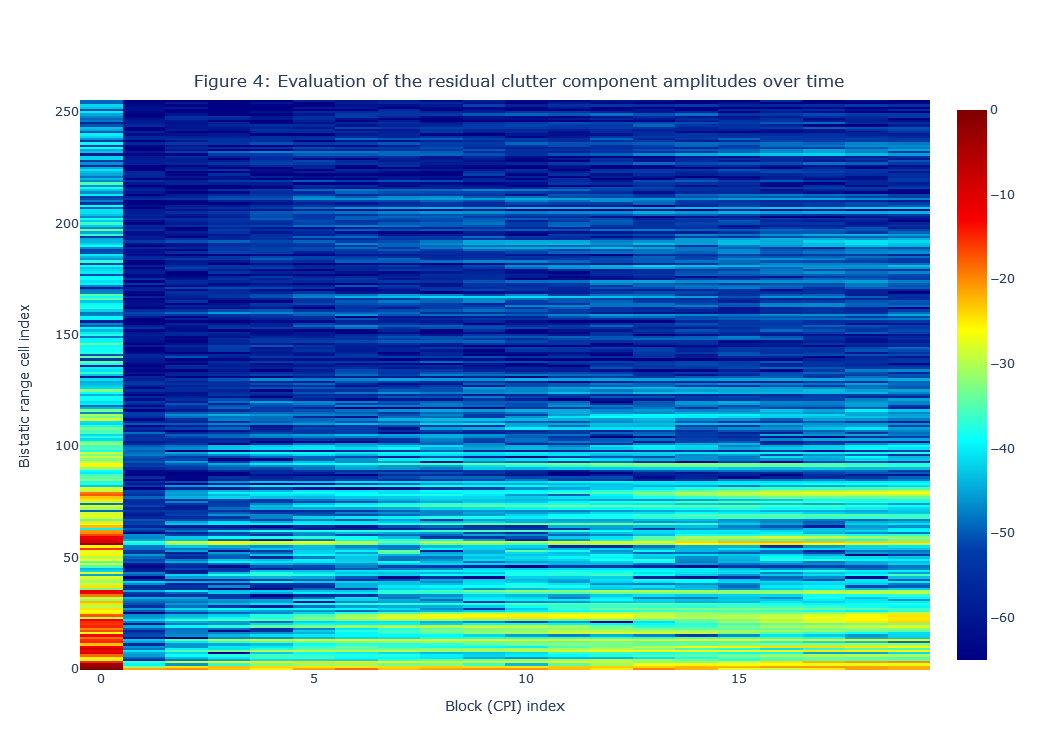

In [8]:
#This figure show the evauluation of the amplitude of the residual clutter power over time
fig = display_zdm_2d(ZDV, "Figure 4: Evaluation of the residual clutter component amplitudes over time")
fig.show()

In Figure 4 it is clearly visible that the clutter filtering operates correctly on the first few CPIs and its performance decreases with time.

According to the previous formulas let us now update the filter coefficient vector only at every second CPIs, hence the filter becomes adaptive, but at the same time we can save compuational resoures. 

In [9]:
filter_update_rate = 2 # Filter coefficients will be updated at every n-th CPI
ZDV = np.zeros([K,T], dtype=np.complex)
ZDV_t =0
for t in np.arange(start_record_index, stop_record_index,1):
    print("Processing time index: {:d}".format(t), end="\r")
    # Load IQ samples
    fname = join(path_prefix, dset_name[0:-4]+"_"+str(t)+".iqf")   
    iq_samples, iq_header = IQRecordTools.load_iq(fname)
    ref_ch=iq_samples[ref_ch_index,0:N]
    surv_ch=iq_samples[surv_ch_index,0:N]
    
    if t == start_record_index:        
        filt_ch, w = cc.Wiener_SMI(ref_ch, surv_ch, K, imp="direct_matrix")
        filt_ch = surv_ch # The first CPI is used as as a reference
    elif ZDV_t % filter_update_rate ==0:
        filt_ch = clutter_filtering(ref_ch, surv_ch, w)    
        filt_ch_tmp, w = cc.Wiener_SMI(ref_ch, surv_ch, K, imp="direct_matrix")
    else:
        filt_ch = clutter_filtering(ref_ch, surv_ch, w)    
    # Calculate zero-Doppler clutter vector
    ZDV[:, ZDV_t] = correlate(filt_ch, ref_ch, mode='full')[N-1:N+K-1]
    ZDV_t += 1

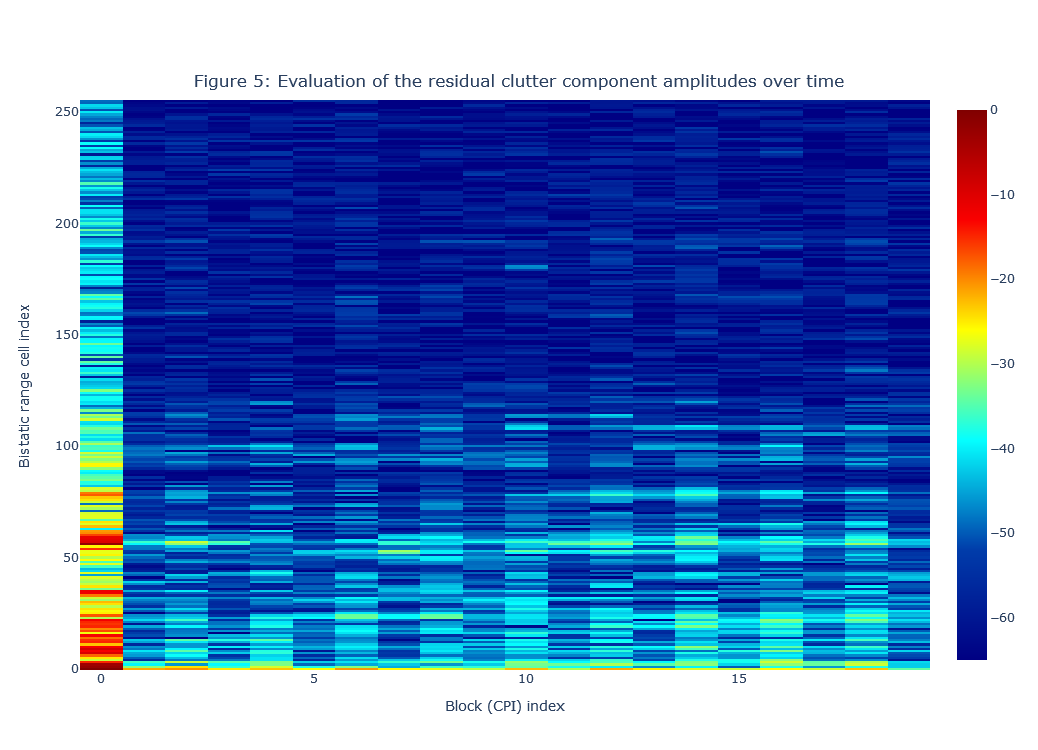

In [10]:
fig = display_zdm_2d(ZDV, "Figure 5: Evaluation of the residual clutter component amplitudes over time" )
fig.show()

Comparing Fig. 4 and Fig. 5 we can observe that the power of the residual clutter is decreased due to adaptivity. This results is close to what Kulpa et al. have found in their research, despite the fact that in the present case the mesurement environment was more complex (DVB-T SFN).

The first results are definitely convincing, however to the correct evaluation of the proposed filtering technique, a quantitative analysis should be carried out.
Moreover as Kulpa has also pointed out "Further investigation is needed to determine the source of 
clutter instability and dynamic of the process in different 
environments"[Kulpa2019]

In the upcomming parts I am going to focus on these points.

## References

[Kulpa2019]  K. Kulpa, B. Osiński, D. Gromek, P. Samczyński, M. Malanowski, M. Bączyk : *Ground Clutter Stability Analises in DAB based Passive Radar*,  2019 Signal Processing Symposium (SPSympo), 17-19 Sept. 2019, Krakow, Poland 

[Peto2020a] Tamas Pető (2020): *Vega Data Repository of Passive Radar Measurements*, VEGAM20200403L2C0S0DVBT, [Data set]. http://tamaspeto.com/vega

[Peto2020b] Tamás Pető: pyAPRiL 1.6.post2 10 march 2020, https://github.com/petotamas/APRiL, https://pypi.org/project/pyAPRiL/#data